In [7]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx

# Load data
with open('./data/chinanews_analysis_results_char_count.json', 'r', encoding='utf-8') as f:
    char_count = json.load(f)

with open('./data/chinanews_analysis_results_cooccur_prob.json', 'r', encoding='utf-8') as f:
    cooccur_prob = json.load(f)

In [8]:
# Cleaning function
def clean_chinese_data(char_count, cooccur_prob):
    """
    Clean Chinese character data by removing non-Chinese characters and stop words.
    Handle tuple-formatted pair strings, e.g., "('炸', '裂')" -> "炸裂"
    """
    import re
    
    print("=== Starting data cleaning ===")
    
    # 1. Define stop characters set
    stop_chars = {
        '的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '上', '也', '很', '到', '说', '要', '去', '你', '会',
        '着', '没有', '看', '好', '自己', '这', '那', '他', '她', '它', '我们', '你们', '他们', '啊', '呀', '呢', '吗', '吧', '哦',
        '唉', '嗯', '哈', '呵', '啦', '哇', '咦', '哟', '呗', '啰', '嘛', '呐', '哩', '咯', '啵', '喔', '噢', '咚', '嘘', '嘿',
        '嗨', '哼', '呸', '哎', '喂', '嘻', '哼', '嗯', '唔', '呃', '诶'
    }
    
    # 2. Define non-Chinese character pattern
    non_chinese_pattern = re.compile(r'[^\u4e00-\u9fa5]')
    
    # 3. Clean char_count
    cleaned_char_count = {}
    for char, count in char_count.items():
        # Remove non-Chinese characters
        if non_chinese_pattern.match(char):
            continue
        # Remove stop characters
        if char in stop_chars:
            continue
        # Remove low-frequency characters (possible noise)
        if count < 3:
            continue
        cleaned_char_count[char] = count
    
    print(f"Number of Chinese characters before cleaning: {len(char_count)}")
    print(f"Number of Chinese characters after cleaning: {len(cleaned_char_count)}")
    
    # 4. Parse and clean cooccur_prob
    cleaned_cooccur_prob = {}
    valid_pairs_count = 0
    invalid_pairs_count = 0
    
    def parse_pair_string(pair_str):
        """
        Parse tuple-formatted pair strings
        e.g., "('炸', '裂')" -> ("炸", "裂")
        """
        # Method 1: Standard tuple format parsing
        if pair_str.startswith("('") and pair_str.endswith("')"):
            inner_str = pair_str[2:-2]  # Remove "('" and "')"
            parts = inner_str.split("', '")
            if len(parts) == 2:
                return parts[0], parts[1]
        
        # Method 2: Backup parsing scheme
        if "', '" in pair_str:
            parts = pair_str.split("', '")
            if len(parts) == 2:
                char1 = parts[0].replace("('", "").replace("'", "")
                char2 = parts[1].replace("')", "").replace("'", "")
                return char1, char2
        
        return None, None
    
    for pair_str, prob in cooccur_prob.items():
        # Parse pair string
        char1, char2 = parse_pair_string(pair_str)
        
        if char1 is None or char2 is None:
            invalid_pairs_count += 1
            continue
        
        # Check character validity
        char1_valid = (not non_chinese_pattern.match(char1) and 
                      char1 not in stop_chars and 
                      char1 in cleaned_char_count)
        
        char2_valid = (not non_chinese_pattern.match(char2) and 
                      char2 not in stop_chars and 
                      char2 in cleaned_char_count)
        
        if char1_valid and char2_valid:
            # Create standardized pair key
            standard_pair = char1 + char2
            cleaned_cooccur_prob[standard_pair] = prob
            valid_pairs_count += 1
        else:
            invalid_pairs_count += 1
    
    print(f"Number of co-occurrence pairs before cleaning: {len(cooccur_prob)}")
    print(f"Number of co-occurrence pairs after cleaning: {len(cleaned_cooccur_prob)}")
    print(f"Valid pairs: {valid_pairs_count}, Invalid pairs: {invalid_pairs_count}")
    
    # 5. Display cleaning result statistics
    if cleaned_cooccur_prob:
        print(f"\nCleaning result statistics:")
        probs = list(cleaned_cooccur_prob.values())
        print(f"  Minimum probability: {min(probs):.6f}")
        print(f"  Maximum probability: {max(probs):.6f}")
        print(f"  Average probability: {sum(probs)/len(probs):.6f}")
        print(f"  Non-zero probability ratio: {sum(1 for p in probs if p > 0)/len(probs):.4f}")
        
        # Display top 10 high-frequency Chinese characters
        print(f"\nTop 10 high-frequency Chinese characters:")
        top_chars = sorted(cleaned_char_count.items(), key=lambda x: x[1], reverse=True)[:10]
        for i, (char, count) in enumerate(top_chars):
            print(f"  {i+1}. {char}: {count} times")
        
        # Display top 10 strong co-occurrence pairs
        print(f"\nTop 10 strong co-occurrence pairs:")
        strong_pairs = sorted(cleaned_cooccur_prob.items(), key=lambda x: x[1], reverse=True)[:10]
        for i, (pair, prob) in enumerate(strong_pairs):
            print(f"  {i+1}. {pair}: {prob:.6f}")
    else:
        print("\nWarning: No co-occurrence pairs retained after cleaning!")
    
    return cleaned_char_count, cleaned_cooccur_prob

# Statistical analysis function
def analyze_cleaned_data(cleaned_char_count, cleaned_cooccur_prob):
    """
    Perform statistical analysis on cleaned data
    """
    # 1. Get high-frequency Chinese characters (top 10)
    top_chars = dict(Counter(cleaned_char_count).most_common(50))
    top_char_list = list(top_chars.keys())
    
    print(f"\nTop 10 high-frequency Chinese characters:")
    for i, (char, count) in enumerate(Counter(cleaned_char_count).most_common(10)):
        print(f"{i+1}. {char}: {count} times")
    
    # 2. Construct probability matrix
    prob_matrix = np.zeros((len(top_char_list), len(top_char_list)))
    for i, char_i in enumerate(top_char_list):
        for j, char_j in enumerate(top_char_list):
            pair = f"{char_i}{char_j}"
            prob_matrix[i, j] = cleaned_cooccur_prob.get(pair, 0)
    # Debug information: print statistics of the probability matrix
    print(f"\nProbability matrix statistics:")
    print(f"Minimum value: {np.min(prob_matrix):.6f}")
    print(f"Maximum value: {np.max(prob_matrix):.6f}")
    print(f"Average value: {np.mean(prob_matrix):.6f}")
    print(f"Number of non-zero elements: {np.sum(prob_matrix > 0)}")
    
    # If there are non-zero values, print the top few largest probabilities
    non_zero_probs = prob_matrix[prob_matrix > 0]
    if len(non_zero_probs) > 0:
        sorted_probs = np.sort(non_zero_probs)[::-1]
        print(f"Top 5 largest probabilities: {sorted_probs[:5]}")
    
    # 3. Statistical analysis
    analysis_results = {
        'top_chars': top_char_list,
        'prob_matrix': prob_matrix,
        'char_freq': [cleaned_char_count[char] for char in top_char_list],
        'max_prob': np.max(prob_matrix),
        'mean_prob': np.mean(prob_matrix),
        'non_zero_ratio': np.sum(prob_matrix > 0) / prob_matrix.size,
        'strong_pairs': []
    }
    
    # 4. Identify strong co-occurrence relationships - adjust threshold
    # If probability values are generally very small, use a relative threshold
    if np.max(prob_matrix) > 0:
        # Use a percentage of the maximum value as the threshold
        threshold = np.max(prob_matrix) * 0.1  # 10% of the maximum value
    else:
        threshold = 0
    
    print(f"Threshold used: {threshold:.6f}")
    
    for i, char_i in enumerate(top_char_list):
        for j, char_j in enumerate(top_char_list):
            prob = prob_matrix[i, j]
            if prob > threshold:
                analysis_results['strong_pairs'].append((char_i, char_j, prob))
    
    analysis_results['strong_pairs'].sort(key=lambda x: x[2], reverse=True)
    
    return analysis_results

# Visualization function
def create_cleaned_visualizations(analysis_results):
    """
    Create visualizations for cleaned data
    """
    top_chars = analysis_results['top_chars']
    prob_matrix = analysis_results['prob_matrix']
    char_freq = analysis_results['char_freq']
    strong_pairs = analysis_results['strong_pairs']
    
    # Set Chinese fonts
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'Heiti TC', 'WenQuanYi Zen Hei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Heatmap
    im = sns.heatmap(prob_matrix, 
                    xticklabels=top_chars, 
                    yticklabels=top_chars,
                    cmap='Blues', 
                    ax=axes[0,0],
                    cbar_kws={'label': 'Co-occurrence Probability'})
    axes[0,0].set_title('Heatmap of Cleaned Chinese Character Adjacent Co-occurrence Probabilities', fontsize=14, pad=20)
    axes[0,0].set_xlabel('Following Character', fontsize=12)
    axes[0,0].set_ylabel('Leading Character', fontsize=12)
    
    # 2. Probability Distribution Histogram
    flat_probs = prob_matrix.flatten()
    flat_probs = flat_probs[flat_probs > 0]  # Only show non-zero probabilities
    axes[0,1].hist(flat_probs, bins=50, alpha=0.7, color='#456990', edgecolor='darkgreen')
    axes[0,1].set_title('Histogram of Co-occurrence Probabilities', fontsize=14, pad=20)
    axes[0,1].set_xlabel('Co-occurrence Probability', fontsize=12)
    axes[0,1].set_ylabel('Frequency', fontsize=12)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Frequency of High-Frequency Chinese Characters
    axes[1,0].bar(range(len(top_chars)), char_freq, color='#48C0AA', edgecolor='darkgreen', alpha=0.7)
    axes[1,0].set_title('Frequency of Cleaned High-Frequency Chinese Characters', fontsize=14, pad=20)
    axes[1,0].set_xlabel('Chinese Character', fontsize=12)
    axes[1,0].set_ylabel('Frequency', fontsize=12)
    axes[1,0].set_xticks(range(len(top_chars)))
    axes[1,0].set_xticklabels(top_chars, rotation=45, fontsize=8)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Strongest Co-occurrence Relationships (Top 15)
    if len(strong_pairs) > 15:
        display_pairs = strong_pairs[:15]
    else:
        display_pairs = strong_pairs
    
    pairs_chars = [f"{p[0]}→{p[1]}" for p in display_pairs]
    pairs_probs = [p[2] for p in display_pairs]
    print(pairs_chars)
    print(pairs_probs)
    bars = axes[1,1].barh(range(len(pairs_chars)), pairs_probs, color='#EF767A', edgecolor='darkgreen', alpha=0.7)
    axes[1,1].set_title('Strongest Co-occurrence Pairs', fontsize=14, pad=20)
    axes[1,1].set_xlabel('Co-occurrence Probability', fontsize=12)
    axes[1,1].set_yticks(range(len(pairs_chars)))
    axes[1,1].set_yticklabels(pairs_chars, fontsize=10)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[1,1].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                      f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('./picture/chinanews_cleaned_cooccurrence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return display_pairs

def create_cleaned_network_graph(analysis_results, display_pairs):
    """
    Create cleaned network graph
    """
    G = nx.DiGraph()
    
    # Add nodes and edges
    for char_i, char_j, prob in display_pairs:
        G.add_edge(char_i, char_j, weight=prob*200)  # Scale weight for better visualization
    
    # Draw network graph
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, k=2, iterations=100)
    
    # Node size based on degree centrality
    node_sizes = [G.degree(char) * 500 + 1000 for char in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                         node_size=node_sizes, 
                         node_color='lightblue', 
                         alpha=0.8,
                         edgecolors='darkblue',
                         linewidths=2)
    
    # Draw edges
    edges = nx.draw_networkx_edges(G, pos, 
                                edge_color='black', 
                                width=[G[u][v]['weight']/50 for u,v in G.edges()],
                                alpha=0.6, 
                                arrows=True, 
                                arrowsize=25,
                                arrowstyle='->')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, 
                          font_size=12, 
                          font_family='sans-serif',
                          font_weight='bold')
    
    plt.title('Cleaned Chinese Character Co-occurrence Network Graph', fontsize=16, pad=20)
    plt.axis('off')
    plt.savefig('./picture/chinanews_cleaned_cooccurrence_network.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution flow
def main():
    print("Starting data cleaning...")
    cleaned_char_count, cleaned_cooccur_prob = clean_chinese_data(char_count, cooccur_prob)
    
    print("\nStarting statistical analysis...")
    analysis_results = analyze_cleaned_data(cleaned_char_count, cleaned_cooccur_prob)
    
    print(f"\nStatistical Analysis Results:")
    print(f"Maximum Co-occurrence Probability: {analysis_results['max_prob']:.4f}")
    print(f"Average Co-occurrence Probability: {analysis_results['mean_prob']:.6f}")
    print(f"Non-zero Probability Ratio: {analysis_results['non_zero_ratio']:.4f}")
    print(f"Number of Strong Co-occurrence Pairs: {len(analysis_results['strong_pairs'])}")
    
    print("\nCreating visualizations...")
    display_pairs = create_cleaned_visualizations(analysis_results)
    create_cleaned_network_graph(analysis_results, display_pairs)
    
    # Output strongest co-occurrence pairs
    print("\nTop 10 Strongest Co-occurrence Chinese Character Pairs:")
    for i, (char_i, char_j, prob) in enumerate(analysis_results['strong_pairs'][:10]):
        print(f"{i+1}. {char_i} → {char_j}: {prob:.4f}")
    
    # Save cleaned data
    with open('./data/chinanews_cleaned_char_count.json', 'w', encoding='utf-8') as f:
        json.dump(cleaned_char_count, f, ensure_ascii=False, indent=2)
    
    with open('./data/chinanews_cleaned_cooccur_prob.json', 'w', encoding='utf-8') as f:
        json.dump(cleaned_cooccur_prob, f, ensure_ascii=False, indent=2)
    
    print("\nCleaned data has been saved as 'chinanews_cleaned_char_count.json' and 'chinanews_cleaned_cooccur_prob.json'")



Starting data cleaning...
=== Starting data cleaning ===
Number of Chinese characters before cleaning: 3970
Number of Chinese characters after cleaning: 3156
Number of co-occurrence pairs before cleaning: 165592
Number of co-occurrence pairs after cleaning: 120528
Valid pairs: 120528, Invalid pairs: 45064

Cleaning result statistics:
  Minimum probability: 0.000026
  Maximum probability: 1.000000
  Average probability: 0.020717
  Non-zero probability ratio: 1.0000

Top 10 high-frequency Chinese characters:
  1. 国: 38232 times
  2. 中: 33868 times
  3. 新: 32038 times
  4. 视: 16655 times
  5. 大: 15524 times
  6. 际: 14973 times
  7. 体: 11724 times
  8. 观: 11707 times
  9. 法: 11265 times
  10. 经: 9967 times

Top 10 strong co-occurrence pairs:
  1. 咨询: 1.000000
  2. 砥砺: 1.000000
  3. 漳州: 1.000000
  4. 踊跃: 1.000000
  5. 魅力: 1.000000
  6. 夯实: 1.000000
  7. 蔓延: 1.000000
  8. 擘画: 1.000000
  9. 夸大: 1.000000
  10. 蔗糖: 1.000000

Starting statistical analysis...

Top 10 high-frequency Chinese charac

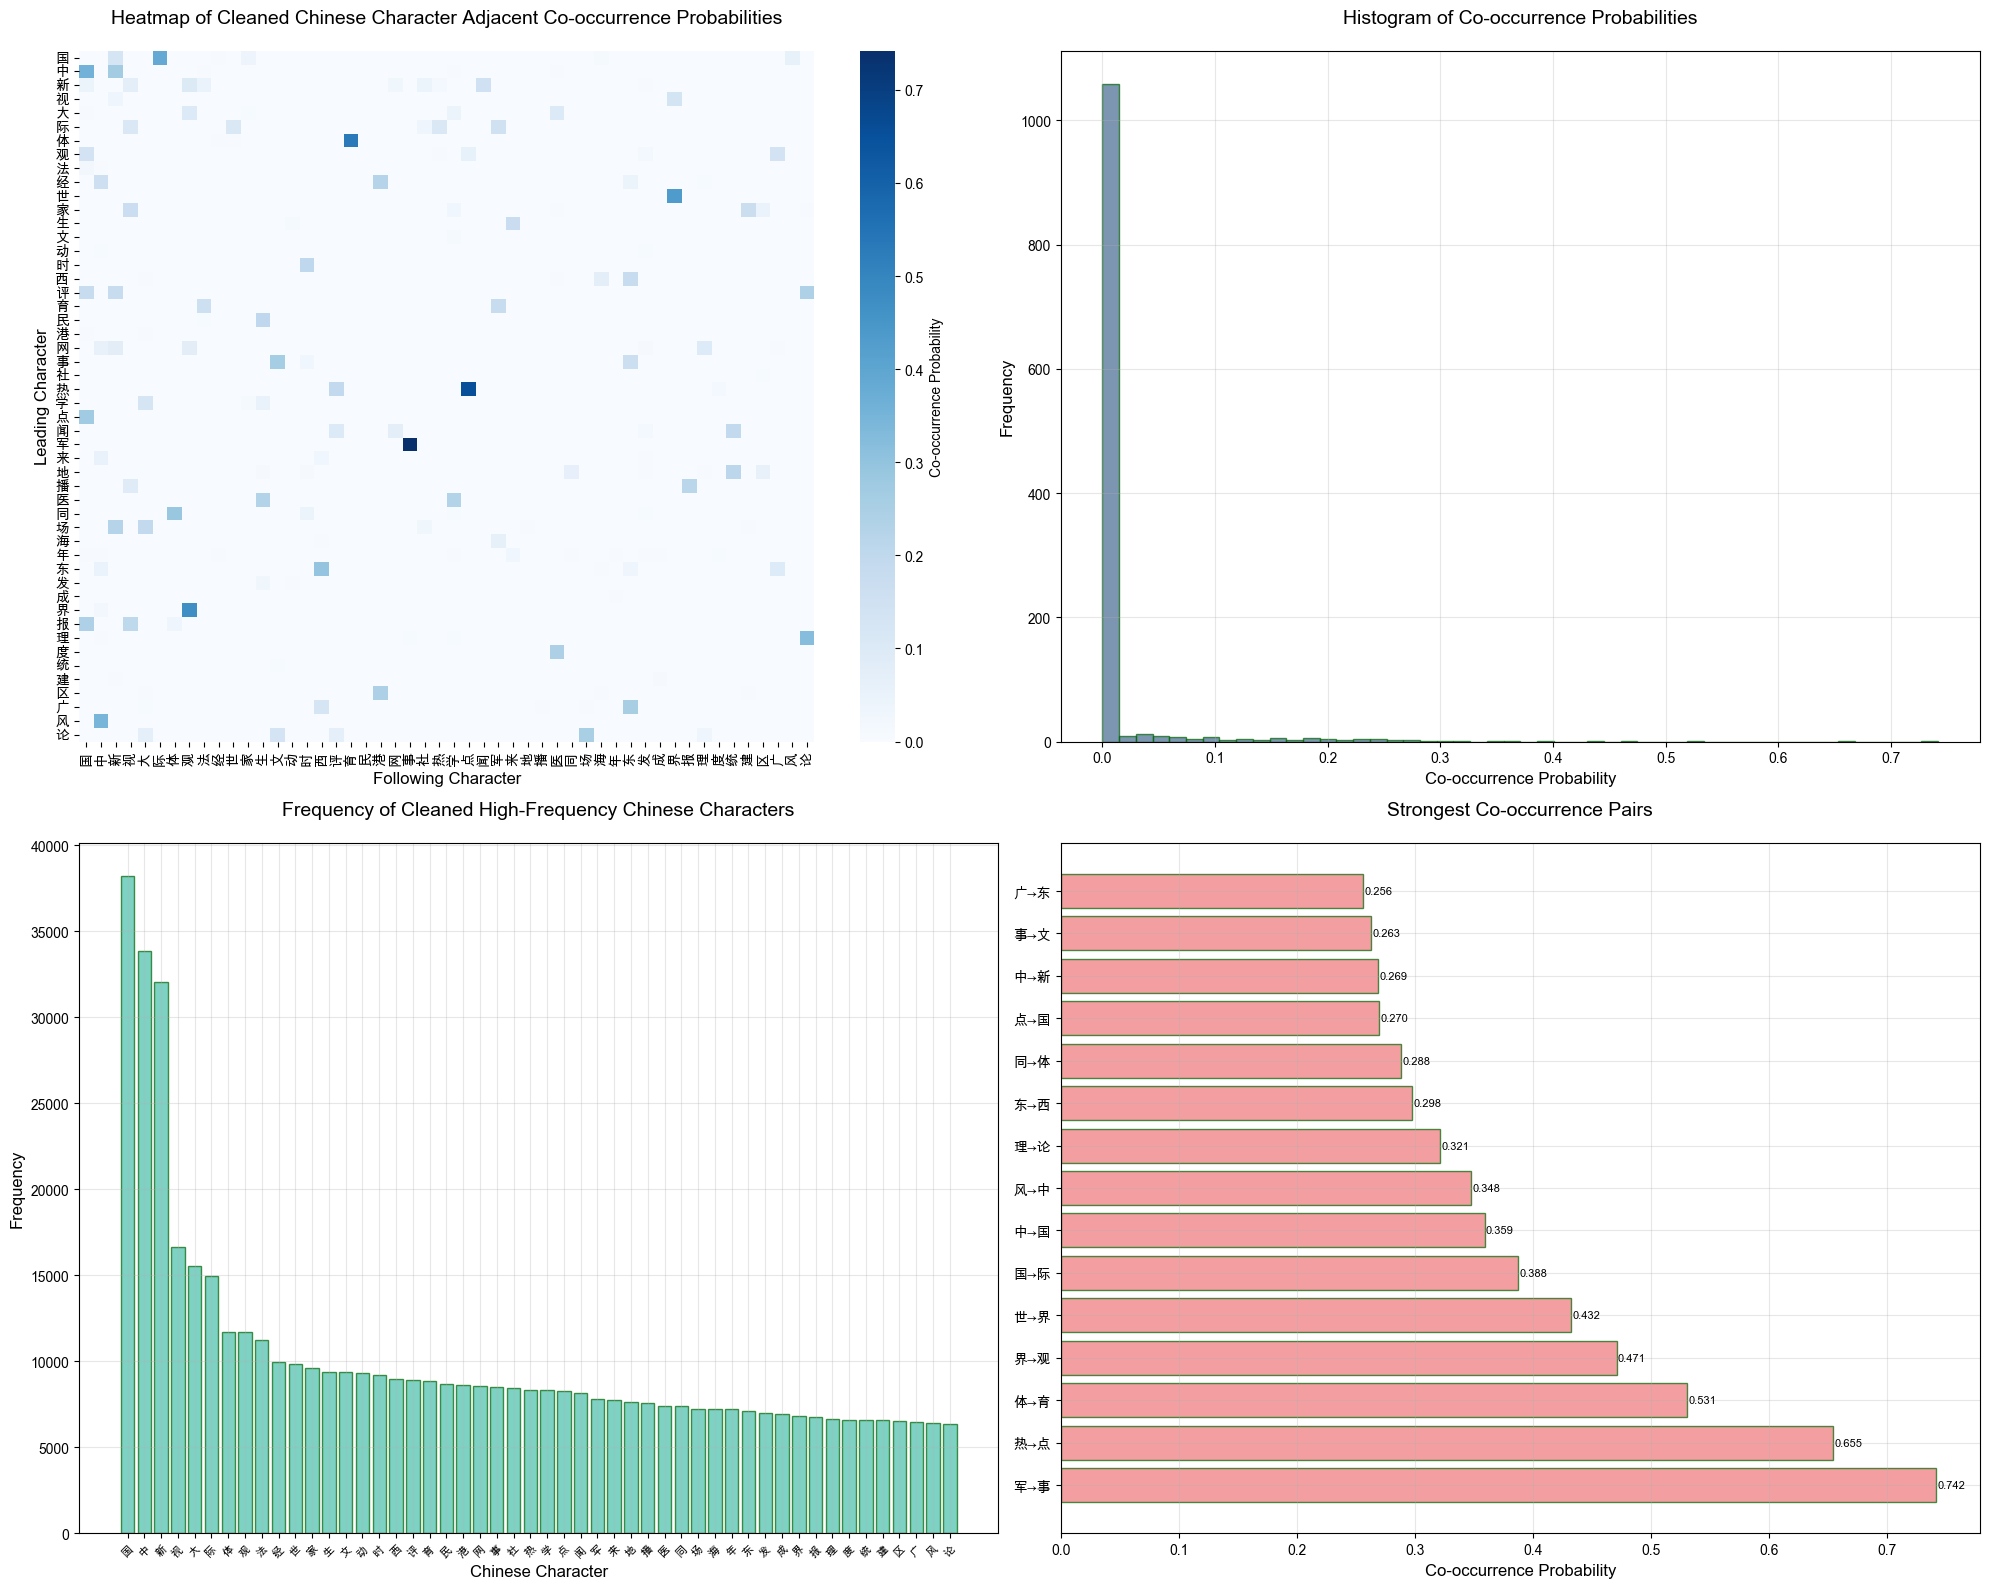

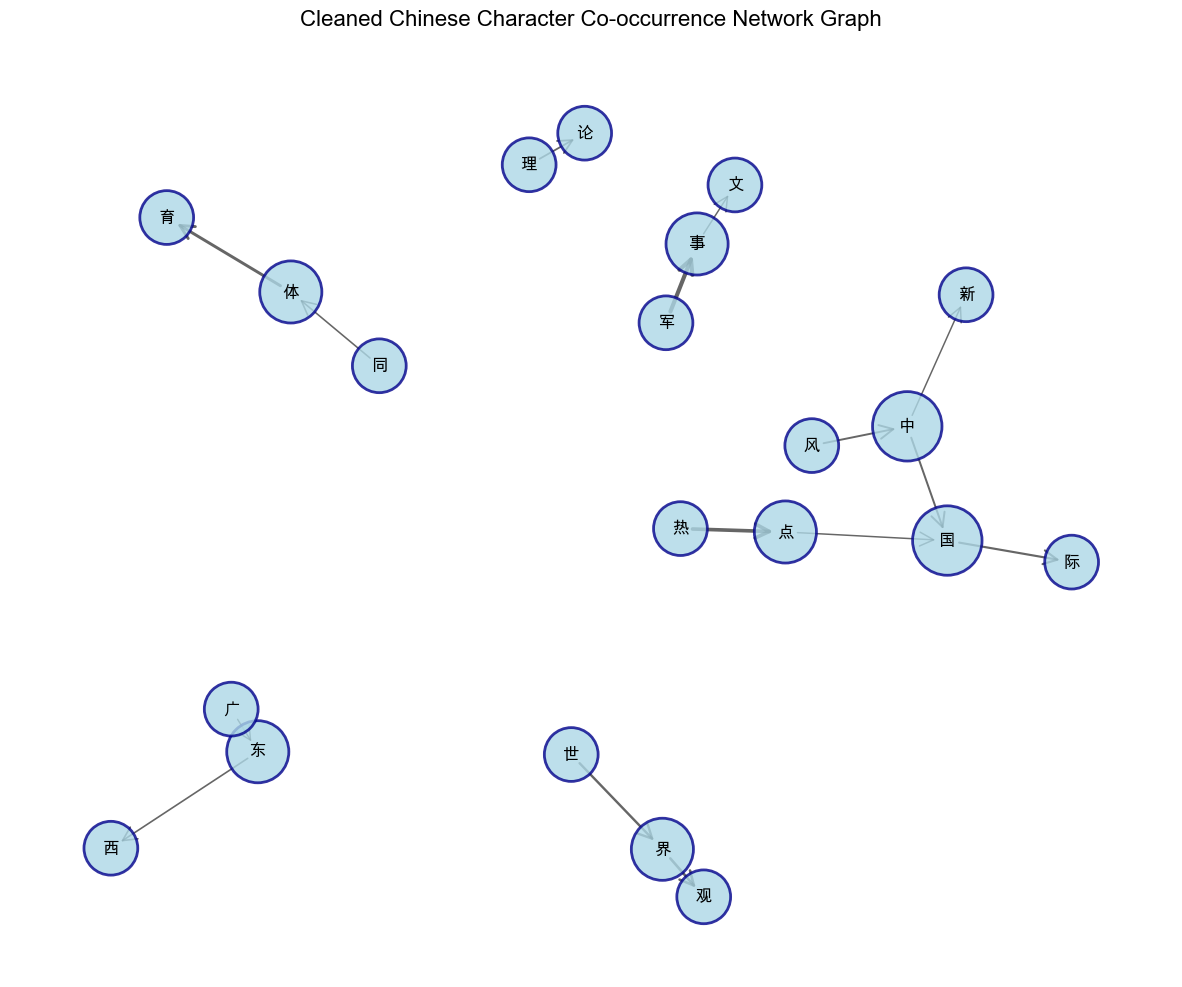


Top 10 Strongest Co-occurrence Chinese Character Pairs:
1. 军 → 事: 0.7419
2. 热 → 点: 0.6546
3. 体 → 育: 0.5310
4. 界 → 观: 0.4710
5. 世 → 界: 0.4323
6. 国 → 际: 0.3879
7. 中 → 国: 0.3593
8. 风 → 中: 0.3480
9. 理 → 论: 0.3214
10. 东 → 西: 0.2980

Cleaned data has been saved as 'chinanews_cleaned_char_count.json' and 'chinanews_cleaned_cooccur_prob.json'


In [9]:
if __name__ == "__main__":
    main()